<a href="https://colab.research.google.com/github/lingzhou0/math412-fall2025/blob/main/Topic6-time-series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TDA + Time Series

Author: Ling Zhou
Date: 10/08/2025

(This notebook is inspired by Jose Perea and Anibal M. Medina-Mardones's lecture notes, and this tutorial: https://giotto-ai.github.io/gtda-docs/latest/notebooks/topology_time_series.html)

In [1]:
!pip install ripser

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.3/827.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.3 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18104 sha256=22dff9e21307c9d46077304e206dc503ca8c90406509a00c5416e6010d958715
  Stored in directory: /root/.cache/pip/wheels/2a/fd/fe/f4b8fd82894e1d9e04040ef41dc5ae6eb7a8e9b0ef5a9402fe
Successfully built hopcroftkarp


In [2]:
# topological data analysis
from ripser import ripser
from persim import plot_diagrams

# plotting and visualization
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

# Numerical
from scipy.spatial import distance
from scipy.interpolate import CubicSpline
from scipy.stats import kendalltau
import numpy as np




---



# Part I : Persistent Homology

### Computing Persistence via Ripser

U. Bauer: "Ripser is a lean C++ code for the computation of Vietoris–Rips persistence barcodes. It can do just this one thing, but does it extremely well."

Original C++ library : https://github.com/Ripser/ripser

Accompanying paper : https://arxiv.org/pdf/1908.02518.pdf

Python library: https://ripser.scikit-tda.org/en/latest


### Data Example 1: A Noisy Circle

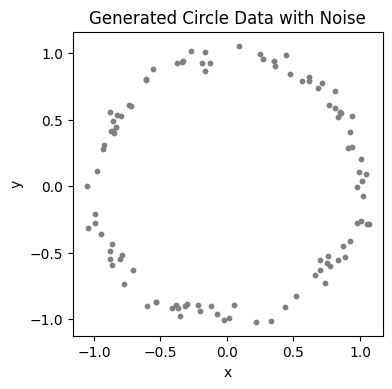

In [4]:
# Generate data points from a circle with noise
np.random.seed(1)
n_data = 100
theta = np.random.rand(n_data) * 2 * np.pi
data = np.array([np.cos(theta), np.sin(theta)]).T
data += 0.05 * np.random.randn(*data.shape)

plt.figure(figsize=(4,4))
plt.scatter(data[:, 0], data[:, 1], s=10, color='grey')
plt.title('Generated Circle Data with Noise')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal', adjustable='box') # Set aspect ratio to equal
plt.show()

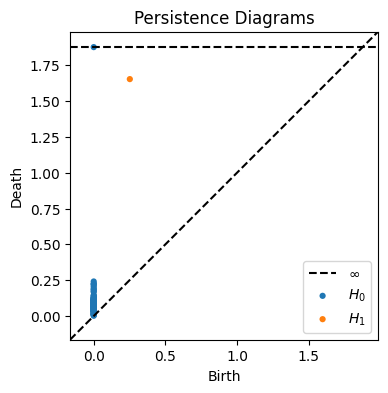

In [5]:
# Compute persistence
dgms = ripser(data, maxdim = 1)['dgms']

# Plot persistence diagrams
plt.figure(figsize=(4,4))
plot_diagrams(dgms, title='Persistence Diagrams')

### Data Example 2: A Noisy Torus

In [6]:
np.random.seed(2)
n_data = 25000
R = 5
r = 2
data = np.zeros((3, n_data))
s = np.random.rand(n_data)*2*np.pi
t = np.random.rand(n_data)*2*np.pi

data[0] = (R + r*np.cos(s))*np.cos(t)
data[1] = (R + r*np.cos(s))*np.sin(t)
data[2] = r*np.sin(s)
data += 0.1*np.random.randn(*data.shape)
data = data.T

# Plot the data
fig = go.Figure(data=[go.Scatter3d(
    x=data.T[0], y=data.T[1], z=data.T[2],
    mode ='markers',
    marker=dict(size = 1.5 , color = 'grey'))])

fig.update_layout( width=900, height=450)
fig.show()

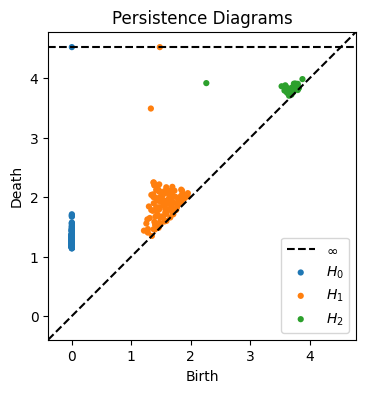

In [7]:
## Persistence Computation

# Parameters
thresh = 4.2 # force the fitration to stop after a certain value
n_perm = 200 # number of landmarks
max_homology_dim = 2


# Run Ripser
rips_persistence = ripser(data,  maxdim=max_homology_dim , thresh = thresh , n_perm = n_perm)

# Visualize barcodes
dgms = rips_persistence['dgms']

plt.figure(figsize=(4,4))
plot_diagrams(dgms, title='Persistence Diagrams')

In [8]:
idx_landmarks = rips_persistence['idx_perm']
landmarks = data[idx_landmarks]

# Plot the data with landmarks highlighted in 3D
fig = go.Figure(data=[
    go.Scatter3d(
        x=data.T[0], y=data.T[1], z=data.T[2],
        mode='markers',
        marker=dict(size=1, color='grey'),
        name='Data points'
    ),
    go.Scatter3d(
        x=landmarks.T[0], y=landmarks.T[1], z=landmarks.T[2],
        mode='markers',
        marker=dict(size=2, color='red'),
        name='Landmark points'
    )
])

fig.update_layout(width=900, height=450)
fig.show()



---



# Part II: Sliding windows and persistence


In [1]:
import numpy as np
import plotly.graph_objects as go

from sklearn.decomposition import PCA

from gtda.time_series import SingleTakensEmbedding
from gtda.plotting import plot_point_cloud
from gtda.homology import VietorisRipsPersistence

The first step in analysing the topology of time series is to construct a _**time delay embedding**_ or _**sliding window embedding**_ or _**Takens embedding**_, named after [Floris Takens](https://en.wikipedia.org/wiki/Floris_Takens) who pioneered its use in the study of [dynamical systems](https://en.wikipedia.org/wiki/Takens's_theorem).

A time delay embedding can be thought of as sliding a "window" of fixed size over a signal, with each window represented as a point in a (possibly) higher-dimensional space. A simple example is shown in the figure below, where pairs of points in a 1-dimensional signal are mapped to coordinates in a 2-dimensional embedding space.

https://raw.githubusercontent.com/giotto-ai/giotto-tda/6f896531b7c59216fd292018bf73728dea40b7e6/examples/images/time_delay_embedding.gif


Given a time series $f(t)$, one can extract a _**sequence of vectors**_ of the form

$f_i = [f(t_i), f(t_i + \tau), f(t_i + 2 \tau), \ldots, f(t_i + (d-1) \tau)] \in \mathbb{R}^{d}$,

where

- $d$ is the _**embedding dimension**_
- $\tau$ is the _**time delay**_
- $(d-1)\tau$ is known as the **window size**
- the difference between $t_{i+1}$ and $t_i$ is called the **_stride_**.

The **time delay embedding** of $f$ with parameters $(d,\tau)$ is the function

$$
\mathbb{SW}_{d,\tau} f : \mathbb{R} \to \mathbb{R}^{d}\,, \qquad t \to \begin{bmatrix}
           f(t) \\
           f(t + \tau) \\
           f(t + 2\tau) \\
           \vdots \\
           f(t + (d-1)\tau)
         \end{bmatrix}
$$


and the main idea we will explore in this notebook is that if $f$ has a non-trivial recurrent structure, then the image of $\mathbb{SW}_{d,\tau}f$ will have non-trivial topology for appropriate choices of $(d, \tau)$.

In [30]:
def SW_cloud(f, tau, d, n_data, if_print_points=False):
    # Inputs:
    # f : time series -- array of size (2,N) (x and y values) or (1,N) (only y values)
    # tau: delay -- positive real number
    # d : gives embedding dimension d+1 -- integer
    # n_data : desired number of points in SW point cloud -- intenger
    #
    # Output:
    # SW : sliding window point cloud -- array of size (n_data,  d+1)

    #Step 1: turn f into a cubic spline
    if len(f.shape)==1:
        N = len(f)
        x_vals = np.linspace(0,1,N)
        y_vals = f
    else:
        x_vals = f[0]
        y_vals = f[1]

    f = CubicSpline(x_vals , y_vals)

    #Step 2: create the t values where to evaluate SW_f
    t_vals = np.linspace(np.min(x_vals) , np.max(x_vals) - (d-1)*tau, n_data) # the starting t

    #Step 3: evaluate the sliding window point cloud
    SW = []
    for t in t_vals:
        SW_f_t = f(t + np.arange(0,d)*tau)
        if if_print_points:
            print(f"When t_i = {t}, the {d}-dimensional point is, {SW_f_t}")
        SW.append(SW_f_t)

    return np.array(SW)

## A periodic example

As a warm-up, recall that a function is periodic with period $T > 0$ if $f(t + T) = f(t)$ for all $t \in \mathbb{R}$. For example, consider the function $f(t) = \cos(5 t)$ which can be visualised as follows:

### Sliding window embedding

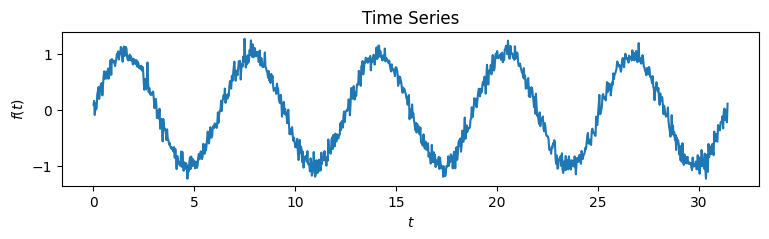

In [27]:
# Time Series Example : Noisy sin(t)

period = 2*np.pi   ## <-- sin(t) is periodic with period 2pi
t_vals = np.linspace(0 , 5*period, 1000)
noise_level = 0.1

y_vals  = np.sin(t_vals) + noise_level*np.random.randn(*t_vals.shape)

plt.figure(figsize = (9,2))
plt.plot(t_vals, y_vals);
plt.title('Time Series');
plt.xlabel('$t$');
plt.ylabel('$f(t)$');


In [39]:
## Compute the Sliding window point cloud

f = np.array([t_vals, y_vals]) ## <---- toy time series

# Parameters for SW
d = 3
tau = period/(d+1)
n_data = 5000

# Compute SW
SW_f = SW_cloud(f,tau, d, n_data, if_print_points=True)

# Plot the sliding window point cloud

fig = go.Figure(data=[go.Scatter3d(
    x=SW_f.T[0], y=SW_f.T[1], z=SW_f.T[2],
    mode ='markers',
    marker=dict(size = 1.5 , color = 'grey'))])

fig.update_layout( width=900, height=450)
fig.show()

When t_i = 0.0, the 3-dimensional point is, [ 0.0922126   1.00826883 -0.13305355]
When t_i = 0.005655997976056839, the 3-dimensional point is, [ 0.18735389  1.03177212 -0.14687205]
When t_i = 0.011311995952113678, the 3-dimensional point is, [ 0.23731142  1.05448457 -0.13936472]
When t_i = 0.016967993928170517, the 3-dimensional point is, [ 0.24970343  1.07554409 -0.11703871]
When t_i = 0.022623991904227356, the 3-dimensional point is, [ 0.23214817  1.09409486 -0.0867954 ]
When t_i = 0.028279989880284195, the 3-dimensional point is, [ 0.19226389  1.10928111 -0.0555362 ]
When t_i = 0.033935987856341034, the 3-dimensional point is, [ 0.13766884  1.12024747 -0.0301625 ]
When t_i = 0.03959198583239787, the 3-dimensional point is, [ 0.07598127  1.12630027 -0.01656732]
When t_i = 0.04524798380845471, the 3-dimensional point is, [ 0.01481944  1.12714745 -0.0149158 ]
When t_i = 0.050903981784511554, the 3-dimensional point is, [-0.03819841  1.12255822 -0.02335327]
When t_i = 0.0565599797605683

In [40]:
len(SW_f)

5000

**Questions**
1. What happens to the sliding window point cloud if the noise level is increased? See what happens.

2. What happens to $\mathbb{SW}_{d,\tau} f$ if $\tau$ is changed (e.g., to 0.1 or 6.1). See what happens.

### Persistent homology of SW_f

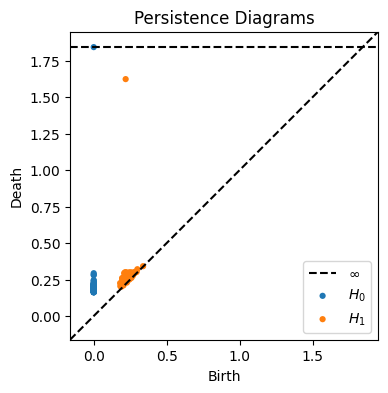

In [42]:
# Parameters
thresh = 1.8
max_homology_dim = 1

# Run Ripser
rips_persistence = ripser(SW_f,  maxdim=max_homology_dim, thresh= thresh, n_perm =200)

# Visualize barcodes
dgms = rips_persistence['dgms']

plt.figure(figsize=(4,4))
plot_diagrams(dgms, title='Persistence Diagrams')

In [43]:
# Maximum 1-dimensional persistence
max_pers_dim_1 = np.max(dgms[1][:, 1] - dgms[1][:, 0])
print('The max persistence in bcd_1 is', max_pers_dim_1)

The max persistence in bcd_1 is 1.4046629816293716


**Questions:**

1. Focus on $\mathrm{bcd}_1^\mathcal{R}(\mathbb{SW}_{d,\tau}f)$. What happens to the length of the longest bar (i.e., to its <u>persistence</u>) if $\tau$ takes sub-optimal values (e.g., 6.0 or 0.1). See what happens.

2. What happens if the noise level is increased? See what happens.

**Your answers:**

1.

2.

---

# Part III: Sliding Windows and 1-Persistence Scoring (SW1PerS)

This activity puts everything together

In [48]:
# Generate a list of synthetic periodic signals corrupted with varying levels of random noise
np.random.seed(2)
t_vals = np.linspace(0,2*np.pi, 1000)

noise = np.random.randn(*t_vals.shape)
noise = noise/np.max(np.abs(noise))

n_signals = 20  # number of signals to be generated

Y_vals = []

for i, noise_level in enumerate(np.linspace(0,1,n_signals)):
  y_vals = (1- noise_level)*np.sin(5*t_vals - np.pi*np.random.rand()) + noise_level*noise
  Y_vals.append(y_vals)

true_ranking = np.random.permutation(n_signals) +1

Y_vals = np.array([Y_vals[i-1] for i in true_ranking])


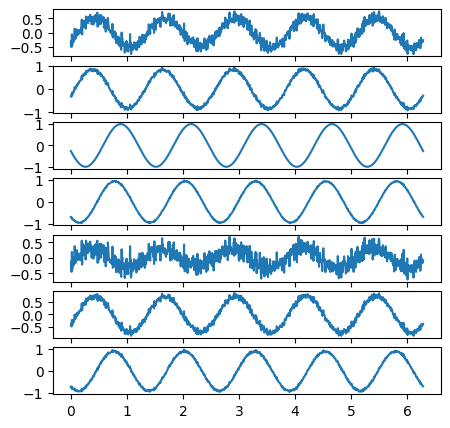

In [49]:
# Plot the first few signals
n_plots = 7
plt.figure(figsize = (5, 5))

for i in range(n_plots):
  plt.subplot(n_plots, 1, i+1)
  plt.plot(t_vals, Y_vals[i])

In [50]:
print('The true ranking of the signals above is: ', true_ranking[0:n_plots])

The true ranking of the signals above is:  [10  4  1  2 14  6  3]


## Comparing Rankings:

*Kendall's tau* is a measure of similarity between two rankings:

$$\mathrm{kendall(ranking_1, ranking_2)} \; \in \; [-1, 1]$$

is a number between  1 (same ranking) and -1 (inverse rankings).  

It’s based on counting how many pairs of items are in the same order vs. reversed order between two lists. More precisely,

$$
\tau = 1 - \frac{4D}{n(n - 1)}
$$

where:
- $n$ = number of items
- $D$ = number of **discordant pairs** (pairs ordered differently in the two lists)

Note:

- τ = +1 → rankings are identical  
- τ =  0 → rankings are unrelated  
- τ = −1 → one ranking is the exact reverse of the other  

See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html for more details

In [51]:
# Compare two rankings use Kendall's tau:

random_ranking = np.arange(n_signals).tolist()

k_tau, _ =  kendalltau(true_ranking, random_ranking)

print('The agreement between the rankings is ', k_tau)

The agreement between the rankings is  0.22105263157894736


**Activity**

1. Apply the SW1PerS algorithm (sliding window point cloud --> persistent homology --> length of longest 1-dimensional bar) to each signal in Y_vals. **Stop and think:** did you use the right parameters?

2. Use sliding window + persistent homology to get a TDA_ranking of the signals. What is the Kendall's tau between the TDA_ranking and the true_ranking? **Stop and think:** is there anything you can do to improve the agreement between the rankings? *Hint:* Noise.

In [52]:
# Your work here

len_bars = []

for i in range(n_signals):
  # Get the time seris
  f =

  # Parameters for SW
  d = 2
  period = 2*np.pi/5
  tau = period/(d+1)  ## <--- the SW theory says this is the best choice
  n_data = 500

  # Compute SW
  SW_f =

  # Persistent homology of SW_f
  # Parameters
  max_alpha = 2
  max_homology_dim = 1

  # Run Ripser and store the length of the longest bar


In [54]:
# Compute the TDA_ranking and compare it with the true_ranking using Kendall's tau

tda_ranking =
k_tau, _ =  kendalltau(true_ranking, tda_ranking)
print('The agreement between the rankings is ', k_tau)

The agreement between the rankings is  0.19999999999999998


# Part IV: Using giotto-tda


In [31]:
!pip install giotto-tda

In [34]:
!pip install scikit-learn==1.3.2 --force-reinstall

  Using cached scikit_learn-1.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.3 MB/s eta 0:00:00
Using cached scikit_learn-1.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 11.5 MB/s eta 0:00:00
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 16.5 MB/s eta 0:00:00
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.6.0
    Uninstalling threadpoolctl-3.6.0:
      Successfully uninstalled threadpoolctl-3.6.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninst

In [44]:
import numpy as np
import plotly.graph_objects as go

x_periodic = np.linspace(0, 10, 1000)
y_periodic = np.cos(5 * x_periodic)

fig = go.Figure(data=go.Scatter(x=x_periodic, y=y_periodic))
fig.update_layout(xaxis_title="Timestamp", yaxis_title="Amplitude")
fig.show()

Let us specify the embedding dimension $d$ and the time delay $\tau$ for the Takens embedding, which in ``giotto-tda`` can be achieved as follows:

In [45]:
from gtda.time_series import SingleTakensEmbedding

embedding_dimension_periodic = 3 # value of d, length of each sequence
embedding_time_delay_periodic = 8 # value of tau, the gap
stride = 10 # value of t_i, the starting place

embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=stride,
)

**Tip:** You can use the `stride` parameter to downsample the time delay embedding. This is handy when you want to quickly compute persistence diagrams on a dense signal.

Let's apply this embedding to our one-dimensional time series $f(t) = \cos(5 t)$ to get a 3-dimensional point cloud:

In [46]:
y_periodic_embedded = embedder_periodic.fit_transform(y_periodic)
plot_point_cloud(y_periodic_embedded)

The periodicity of $f$ is reflected in the ellipticity of the point cloud.
It turns out that in general, through the Takens embedding, periodic functions trace out ellipses in $\mathbb{R}^{d}$.

### A non-periodic example

 Consider the function $g(t) = \cos(t) + \cos(\pi t)$.
 It is clear that $g$ is not periodic since the ratio of the two frequencies is irrational, i.e. $\cos(t)$ and $\cos(\pi t)$ are **incommensurate**.
 Let us plot its graph below.

In [57]:
x_nonperiodic = np.linspace(0, 50, 1000)
y_nonperiodic = np.cos(x_nonperiodic) + np.cos(np.pi * x_nonperiodic)

fig = go.Figure(data=go.Scatter(x=x_nonperiodic, y=y_nonperiodic))
fig.update_layout(xaxis_title="Timestamp", yaxis_title="Amplitude")
fig.show()

As before, let us create a time delay embedding for this signal and visualise the resulting point cloud:

In [58]:
embedding_dimension_nonperiodic = 3
embedding_time_delay_nonperiodic = 16
stride = 3

embedder_nonperiodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_nonperiodic,
    dimension=embedding_dimension_nonperiodic,
    stride=stride,
)

y_nonperiodic_embedded = embedder_nonperiodic.fit_transform(y_nonperiodic)

plot_point_cloud(y_nonperiodic_embedded)

## Persistent homology

`giotto-tda` computes persistent homology as well. We first need to adapt the date to approporiate input for `giotto-tda`(See https://giotto-ai.github.io/gtda-docs/latest/notebooks/vietoris_rips_quickstart.html for more details):

In [59]:
y_periodic_embedded = y_periodic_embedded[None, :, :]
y_nonperiodic_embedded = y_nonperiodic_embedded[None, :, :]

homology_dimensions = [0, 1, 2]

periodic_persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=6
)
print("Persistence diagram for periodic signal")
periodic_persistence.fit_transform_plot(y_periodic_embedded)

nonperiodic_persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=6
)
print("Persistence diagram for nonperiodic signal")
nonperiodic_persistence.fit_transform_plot(y_nonperiodic_embedded);

Persistence diagram for periodic signal


Persistence diagram for nonperiodic signal


What can we conclude from these diagrams? The first thing that stands out is the different types of homology dimensions that are most persistent. In the periodic case we see a single point associated with 1-dimensional persistent homology, namely a loop! On the other hand, the non-periodic signal has revealed two points associated with 2-dimensional persistent homology, namely _voids_. These clear differences in topology make the time delay embedding technique especially powerful at classifying different time series.

## Choice of parameters

In the examples above, we manually chose values for the embedding dimension $d$ and time delay $\tau$.
However, we can be use principled techniques to search for appropriate values of these parameters.

In ``giotto-tda``, these techniques are applied when we select ``parameters_type="search"`` in the ``SingleTakensEmbedding`` transformer, e.g.

```python
embedder = SingleTakensEmbedding(
    parameters_type="search", time_delay=time_delay, dimension=embedding_dimension,
)
```

where the values of `time_delay` and `embedding_dimension` provide upper bounds on the search algorithm.

Read https://giotto-ai.github.io/gtda-docs/latest/notebooks/topology_time_series.html to understand the theory behind.



---

